# TP1

Name

## Loads libraries and external data

In [2]:
# Imports libraries
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

# Loads CSVs into Pandas variables
items = pd.read_csv('items.csv', delimiter= '|')
u = pd.read_csv('u.csv', delimiter= '|')
votes = pd.read_csv('votes.csv', delimiter= '|')

## Excludes the first value from votes (it returns null, not sure why)
votes['user.id'] -= 1
votes['item.id'] -= 1

# Auxiliary Methods - used by the main methods

In [9]:
## Calculates cosine values between the elements of a matrix

def cosine_matrix(mat):
    
    result_matrix = 1.0 * np.matmul(mat.transpose(), mat)
    nb_items = len(mat[0])
    
    for i in range(nb_items):
        norm = np.linalg.norm(mat[:, i])
        result_matrix[i] = result_matrix[i] / norm
        result_matrix[:, i] = result_matrix[:, i] / norm
        result_matrix[i, i] = 1.0 * np.NINF
    
    return result_matrix

## Calculates correlation values between the elements of a matrix

def corr_matrix(mat):

    mat = mat.astype(np.float64)
    n = mat.shape[1]
    
    # Compute the covariance matrix
    rowsum = mat.sum(1)
    centering = rowsum.dot(rowsum.T.conjugate()) / n
    C = (mat.dot(mat.T.conjugate()) - centering) / (n - 1)

    # The correlation coefficients are given by
    d = np.diag(C)
    result_matrix = C / np.sqrt(np.outer(d, d))

    return result_matrix

## Calculates cross validation based on the number of folds given

def cross_validation(data, number_of_folds, seed):
   
    ## Stores the original dataset, using the seed defined as an attribute
    sample_data = data.sample(frac=1, random_state=seed)
    ## Creates variables to store the folds, and to guide the loop
    fold_size = len(sample_data) // number_of_folds
    ini, end, folds = 0, fold_size, []
    ## While it doesn't reach the number of folds, splits data
    for i in range(number_of_folds):
        folds.append(sample_data.iloc[ini:end, :])
        ini = end
        if (i + 1 == number_of_folds - 1):
            end = len(data)
        else:
            end += fold_size
    return folds

## Splits the dataset between train and test samples, based on a percentage given

def train_test_validation(data, percentage, seed):
   
    ## Stores the original dataset, using the seed defined as an attribute
    sample_data = data.sample(frac=1, random_state=seed)
    ## Defines end of the elements using the percentage given
    end = math.floor(percentage * len(sample_data))
    
    train_sample = sample_data.iloc[:end]
    test_sample = sample_data.iloc[end:]
    
    return train_sample, test_sample

## Calculates K in the collaborative filtering algorithm 

def get_K(vote_item_id, w_item_id):
    w_item = np.zeros(vote_item_id.shape)
    for user, v_user_item in enumerate(vote_item_id):
        c_user_item = np.ma.masked_where(v_user_item != 0, v_user_item).mask
        w_item[user] = c_user_item * w_item_id
    w_item = w_item.sum(axis=1)
    w_item = np.true_divide(1, w_item, out=np.zeros_like(w_item), where=w_item != 0)
    return w_item

### Question 1 - Calculez la performance prédictive de quelques approches qui donnent chacune une base de référence : le vote aléatoire, le vote moyen, le vote moyen utilisateur, le vote moyen item et finalement le vote attendu (moyenne du vote moyen utilisateur et item). Raportez l'erreur quadratique moyenne (1) sans validation croisée et (2) avec validation croisée de 10 replis. Déterminez si la différence entre le vote moyen item et le vote moyen utilisateur est statistiquement significative par un test d'hypothèse et en affichant les résultats visuellement.


### Method to calculate the MSE, using the method selected by the user - random, average ratings, average user score, average item score, or expected vote. If the user wants cross validation, they may select the number of folds in the "folds" parameter. If they do not want cross validation, the user must select the percentage to split the dataset into train/test splits. 

In [7]:
def calculate_error(data, use_cross_validation, folds, seed, percentage, method):
    
    overall_error = []
    fold_error, pred_vote = [], 0
    
    ## Calculates error with K-fold cross validation
    if (use_cross_validation): 
        
        folds_data = cross_validation(data,folds,seed)
        
        ## For each fold, calculates average error
        for fold in range(len(folds_data)):

            ## Gets the test-rating split
            test_data = folds_data[fold]

            ## Converts the rating data to 0
            rating_data = test_data.copy()
            rating_data['rating'] = np.nan

            ## Inserts that test-rating split back to the set, and builds train data and CSR matrix from it
            train_data = pd.concat(folds_data[:fold] + [rating_data] + folds_data[fold + 1:])
            train_matrix = csr_matrix((train_data['rating'], (train_data['user.id'], train_data['item.id']))).toarray()
            
            ## For each vote in test data, calculate prediction
            for _, vote in test_data.iterrows():

                ## For the average scores, considers only ratings above 0 (to exclude the rating set)
                avg_vote_user = np.mean(train_matrix[vote["user.id"]][train_matrix[vote["user.id"]] > 0])
                avg_vote_item = np.mean(train_matrix[:, vote["item.id"]][train_matrix[:, vote["item.id"]] > 0])
                
                ## Methods required by the TP
                if (method=="random"):
                    pred_vote = np.random.randint(1,high=6)
                elif (method=="avg_vote"):
                    pred_vote = np.nanmean(train_data['rating'])
                elif (method=="avg_user"):
                    pred_vote = avg_vote_user
                elif (method=="avg_item"):
                    pred_vote = avg_vote_item
                elif (method=="expected"):
                    pred_vote = (avg_vote_user + avg_vote_item) / 2

                ## Feeds the fold error
                fold_error.append((vote["rating"] - pred_vote) ** 2)
            
            mean_fold_error = np.nanmean(fold_error)
            
            ## Feeds the overall error
            overall_error.append(mean_fold_error)
        
        return (overall_error)
       
    ## Calculates error with train-test data split
    else: 
        train_data, test_data = train_test_validation(data, percentage, seed)
        
        ## Converts the rating data to 0
        rating_data = test_data.copy()
        rating_data['rating'] = 0
        
        ## Builds train data and CSR matrix from it. As it is a train-test, just concats the two
        train_data = pd.concat([train_data, rating_data])
        train_matrix = csr_matrix((train_data['rating'], (train_data['user.id'], train_data['item.id']))).toarray()
            
        ## For each vote in test data, calculate prediction
        for _, vote in test_data.iterrows():

            ## Same rule as above
            avg_vote_user = np.mean(train_matrix[vote["user.id"]][train_matrix[vote["user.id"]] > 0])         
            avg_vote_item = np.mean(train_matrix[:, vote["item.id"]][train_matrix[:, vote["item.id"]] > 0])

            ## Methods required by the TP
            if (method=="random"):
                pred_vote = np.random.randint(1,high=6)
            elif (method=="avg_vote"):
                pred_vote = np.mean(train_data['rating'])
            elif (method=="avg_user"):
                pred_vote = avg_vote_user
            elif (method=="avg_item"):
                pred_vote = avg_vote_item
            elif (method=="expected"):
                pred_vote = (avg_vote_user + avg_vote_item) / 2

        ## Feeds the fold error
            fold_error.append((vote["rating"] - pred_vote) ** 2)
        
        return (fold_error)

### Running the code without cross validation - 60% of the set goes to the train set, 40% goes to the test set - for each of the 5 methods required

In [9]:
print(np.nanmean(calculate_error(votes, False, None, 50, 0.6, "random")))
print(np.nanmean(calculate_error(votes, False, None, 50, 0.6, "avg_vote")))
print(np.nanmean(calculate_error(votes, False, None, 50, 0.6, "avg_user")))
print(np.nanmean(calculate_error(votes, False, None, 50, 0.6, "avg_item")))
print(np.nanmean(calculate_error(votes, False, None, 50, 0.6, "expected")))

3.5472
3.2554261436000003
1.0810834397977556
1.0503686194979007
0.9601726988362981


### Running the code with 10-fold cross validation for each of the 5 methods required

In [10]:
print(np.mean(calculate_error(votes, True, 10, 50, None, "random")))
print(np.mean(calculate_error(votes, True, 10, 50, None, "avg_vote")))
print(np.mean(calculate_error(votes, True, 10, 50, None, "avg_user")))
print(np.mean(calculate_error(votes, True, 10, 50, None, "avg_item")))
print(np.mean(calculate_error(votes, True, 10, 50, None, "expected")))

3.555123591269841
1.2665643969949394
1.0863282625135617
1.0392195422801267
0.9618801517550782


### Finding significance between average user vote and user item (using the train-test split as reference). Since our variances are very similar, we adopt the model proposed in https://en.wikipedia.org/wiki/Student%27s_t-test#Equal_or_unequal_sample_sizes,_similar_variances_(1/2_%3C_sX1/sX2_%3C_2)

In [308]:
user_vote = calculate_error(votes, False, None, 50, 0.6, "avg_user")
user_item = calculate_error(votes, False, None, 50, 0.6, "avg_item")

vote_mean = np.nanmean(user_vote)
item_mean = np.nanmean(user_item)

vote_var = np.nanvar(user_vote)
item_var = np.nanvar(user_item)

vote_len = len(user_vote)
item_len = len(user_item)

sp = np.sqrt ((vote_len-1*vote_var**2 +  item_len-1*item_var**2)/vote_len+item_len-2)
t_test = (vote_mean - item_mean) / sp * np.sqrt(1/item_len + 1/vote_len)
print(t_test)

1.0859328893921805e-06


### Therefore, we accept the alternative hypothesis, and there is a statistically significant relationship.

# Question 2 - Calculez l'erreur quadratique moyenne des prédiction des l'approches item-item et utilisateur-utilisateur pour une validation croisée à 5 replis. Utilisez deux mesures de similarité entre items, le cosinus et la corrélation. Utilisez tous les votes disponibles plutôt qu'un calcul avec des voisins rapprochés.

In [7]:
## Q2 using item-item approach

def compute_error_Q2(data, folds, seed, neighbors, method):
    
    overall_error = []
    fold_error, pred_vote = [], 0
    folds_data = cross_validation(data,folds,seed)
    
    ## For each fold, calculates average error
    for fold in range(len(folds_data)):              
        
        ## Gets the test-rating split
        test_data = folds_data[fold]
        
        ## Gets random values in the rating data, to avoid zeros in the similarity matrices
        rating_data = test_data.copy()
        rating_data['rating'] = np.random.randint(1,high=6)        
        
        ## Inserts the rating data back into the folds data, and builds train data and CSR matrix from it
        train_data = pd.concat(folds_data[:fold] + [rating_data] + folds_data[fold + 1:])                
        test_matrix = csr_matrix((train_data['rating'], (train_data['user.id'], train_data['item.id']))).toarray()
       
        ## Selects method to be used to calculate the similarity matrix
        if (method == "cosine"):
            sim_mat = cosine_matrix(test_matrix)
        elif (method == "correlation"):
            sim_mat = corr_matrix(test_matrix.transpose())
        else:
            return None
    
        ## Uses the number of neighbors selected as the parameter
        ind = np.argpartition(sim_mat, -neighbors, axis=0)[-neighbors:]
        w = sim_mat[np.arange(len(sim_mat)), ind]
          
        ## Centralizes data to calculate R_0, and initializes the prediction matrix
        masked = np.ma.masked_where(test_matrix == 0, test_matrix)
        mean = masked.mean(axis=0).filled(0)
        R_0 = (masked - mean).filled(0)
        res = np.zeros(test_matrix.shape)
        
        ## Calculates predictions
        for item_id in range(test_matrix.shape[1]):
            ind_i = ind[:, item_id]
            w_i = w[:, item_id]
            v_0_i = R_0[:, ind_i]
            K_i = get_K(v_0_i, w_i)
            res[:, item_id] = (mean[item_id] + K_i * np.matmul(v_0_i, w_i)).clip(1, 5)
                   
        err = np.full(res.shape, np.nan)            
    
        ## For each row in test-rating data, calculates the squared error
        for _, vote in test_data.iterrows():
            pred = res[vote["user.id"], vote["item.id"]]
            dif = (vote["rating"] - pred)
            err[vote["user.id"], vote["item.id"]] = (dif ** 2)
        
        ## Feeds errors
        mean_err = np.nanmean(err, axis=0)
        mean_mse = np.nanmean(mean_err)
        overall_error.append(mean_err)        
    
    return np.nanmean(overall_error)

### Calculates error using item-item approach, 5-fold, correlation method, 10 neighbors

In [21]:
print(compute_error_Q2(votes, 5, 10, 10, "correlation"))

C:\Users\vbert\AppData\Local\Temp/ipykernel_22840/3086187511.py:56: RuntimeWarning: Mean of empty slice
  mean_err = np.nanmean(err, axis=0)


2.804941100008168


### Calculates error using item-item approach, 5-fold, cosine method, 10 neighbors

In [6]:
print(compute_error_Q2(votes, 5, 10, 10, "cosine"))

C:\Users\vbert\AppData\Local\Temp/ipykernel_18412/3979486087.py:56: RuntimeWarning: Mean of empty slice
  mean_err = np.nanmean(err, axis=0)


1.2852657254776318


In [4]:
## Same as before, but using user-user approach

def compute_error_Q2_user_user(data, folds, seed, neighbors, method):
    
    overall_error = []
    fold_error, pred_vote = [], 0
    folds_data = cross_validation(data,folds,seed)
    
    ## For each fold, calculates average error
    for fold in range(len(folds_data)):              
        
        ## Gets the test-rating split
        test_data = folds_data[fold]
        
        ## Gets random values in the rating data, to avoid zeros in the similarity matrices
        rating_data = test_data.copy()
        rating_data['rating'] = np.random.randint(1,high=6)        
        
        ## Inserts the rating data back into the folds data, and builds train data and CSR matrix from it
        train_data = pd.concat(folds_data[:fold] + [rating_data] + folds_data[fold + 1:])                
        test_matrix = csr_matrix((train_data['rating'], (train_data['item.id'], train_data['user.id']))).toarray()
       
        ## Selects method to be used to calculate the similarity matrix
        if (method == "cosine"):
            sim_mat = cosine_matrix(test_matrix)
        elif (method == "correlation"):
            sim_mat = corr_matrix(test_matrix.transpose())
        else:
            return None
    
        ## Uses the number of neighbors selected as the parameter
        ind = np.argpartition(sim_mat, -neighbors, axis=0)[-neighbors:]
        w = sim_mat[np.arange(len(sim_mat)), ind]
          
        ## Centralizes data to calculate R_0, and initializes the prediction matrix
        masked = np.ma.masked_where(test_matrix == 0, test_matrix)
        mean = masked.mean(axis=0).filled(0)
        R_0 = (masked - mean).filled(0)
        res = np.zeros(test_matrix.shape)
        
        ## Calculates predictions
        for user_id in range(test_matrix.shape[1]):
            ind_i = ind[:, user_id]
            w_i = w[:, user_id]
            v_0_i = R_0[:, ind_i]
            K_i = get_K(v_0_i, w_i)
            res[:, user_id] = (mean[user_id] + K_i * np.matmul(v_0_i, w_i)).clip(1, 5)
                   
        err = np.full(res.shape, np.nan)            
    
        ## For each row in test-rating data, calculates the squared error
        for _, vote in test_data.iterrows():
            pred = res[vote["item.id"], vote["user.id"]]
            dif = (vote["rating"] - pred)
            err[vote["item.id"], vote["user.id"]] = (dif ** 2)
        
        ## Feeds errors
        mean_err = np.nanmean(err, axis=0)
        mean_mse = np.nanmean(mean_err)
        overall_error.append(mean_err)        
    
    return np.nanmean(overall_error)

### Calculates error using user-user approach, correlation method, 5-fold, and 10 neighbors

In [5]:
print(compute_error_Q2_user_user(votes, 5, 10, 10, "correlation"))

C:\Users\vbert\AppData\Local\Temp/ipykernel_11672/2228632374.py:58: RuntimeWarning: Mean of empty slice
  mean_err = np.nanmean(err, axis=0)


2.346239815601421


### Calculates error using user-user approach, cosine method, 5-fold, and 10 neighbors

In [6]:
print(compute_error_Q2_user_user(votes, 5, 10, 10, "cosine"))

C:\Users\vbert\AppData\Local\Temp/ipykernel_11672/2228632374.py:58: RuntimeWarning: Mean of empty slice
  mean_err = np.nanmean(err, axis=0)


1.2891883787031333


### Une version avec voisins rapprochés peut aussi être implémentée afin de déterminer le nombre optimal de voisins (entre 10, 25, 50, ou 100) pour l'approche item-item. Jusqu'à trois points bonus seront accordés pour une implémentation qui tient correctement compte des votes communs et des votes manquants. Le maximum des points à ce TP demeure cependant de 30/30.

In [29]:
user_user_cosine = {}
user_user_corr = {}
item_item_cosine = {}
item_item_corr = {}
neighbor_values = [10,25,50,100]

for value in neighbor_values:
    user_user_cosine.update({value:compute_error_Q2_user_user(votes, 5, 10, value, "cosine")})
    user_user_corr.update({value:compute_error_Q2_user_user(votes, 5, 10, value, "correlation")})
    item_item_cosine.update({value:compute_error_Q2(votes, 5, 10, value, "cosine")})
    item_item_corr.update({value:compute_error_Q2(votes, 5, 10, value, "correlation")})

C:\Users\vbert\AppData\Local\Temp/ipykernel_11672/2228632374.py:58: RuntimeWarning: Mean of empty slice
  mean_err = np.nanmean(err, axis=0)


In [47]:
print(user_user_corr)
print(user_user_cosine)
print(item_item_corr)
print(item_item_cosine)

{10: 2.1244671367304164, 25: 1.6669865285230834, 50: 1.9633379042987757, 100: 1.6146557081576751}
{10: 1.2083436666149034, 25: 1.1273074662533211, 50: 1.0994792859535358, 100: 1.0443841173556438}
{10: 2.8192087686296805, 25: 2.5494360260795013, 50: 2.9350627642891087, 100: 2.7392408112277873}
{10: 1.2930467411054882, 25: 1.4703035105186537, 50: 1.3365215447053473, 100: 2.7392408112277873}


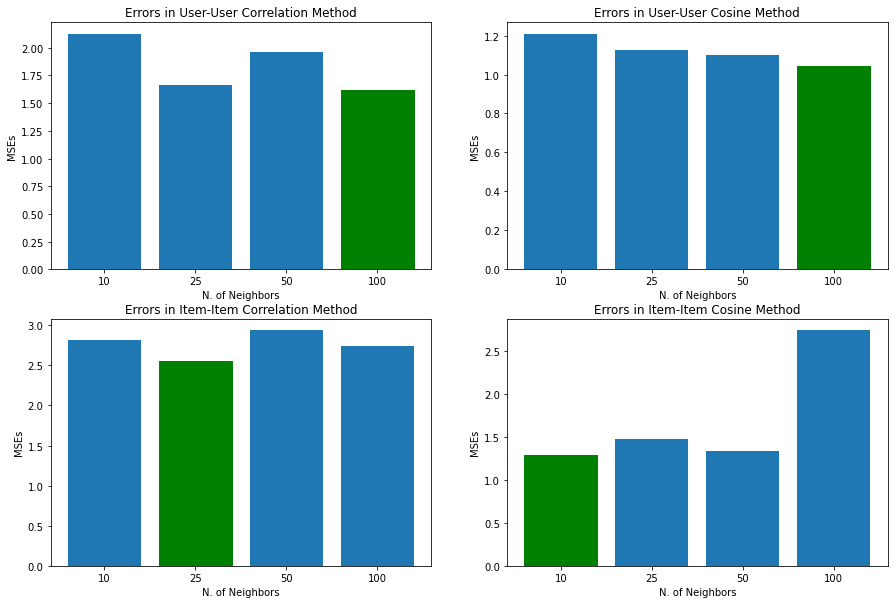

In [76]:
f, axs = plt.subplots(2,2,figsize=(15,10))

plt.subplot(2, 2, 1)
barlist = plt.bar(range(len(user_user_corr)), list(user_user_corr.values()), tick_label=list(user_user_corr.keys()))
barlist[3].set_color('g')
plt.title('Errors in User-User Correlation Method')
plt.xlabel('N. of Neighbors')
plt.ylabel('MSEs')

plt.subplot(2, 2, 2)
barlist = plt.bar(range(len(user_user_cosine)), list(user_user_cosine.values()), tick_label=list(user_user_corr.keys()))
barlist[3].set_color('g')
plt.title('Errors in User-User Cosine Method')
plt.xlabel('N. of Neighbors')
plt.ylabel('MSEs')

plt.subplot(2, 2, 3)
barlist = plt.bar(range(len(item_item_corr)), list(item_item_corr.values()), tick_label=list(item_item_corr.keys()))
barlist[1].set_color('g')
plt.title('Errors in Item-Item Correlation Method')
plt.xlabel('N. of Neighbors')
plt.ylabel('MSEs')

plt.subplot(2, 2, 4)
barlist = plt.bar(range(len(item_item_cosine)), list(item_item_cosine.values()), tick_label=list(item_item_corr.keys()))
barlist[0].set_color('g')
plt.title('Errors in Item-Item Cosine Method')
plt.xlabel('N. of Neighbors')
plt.ylabel('MSEs')

plt.show()

# Question 3 - Utilisez l'approche de factorisation par valeurs singulières (SVD) et calculez l'erreur quadratique moyenne. Déterminez le nombre de dimensions à retenir par une méthode de votre choix. Effectuez une validation croisée de 5 replis.


In [1]:
## Auxiliary methods

## Decomposes a CSR matrix
def svd_decomp(model):
    u, s, vh = np.linalg.svd(model, full_matrices=False)
    return u, np.diag(s), vh

## Reduces the matrix
def svd_decomp_reduc(model, k):
    U, s, V = svd_decomp(model)
    s = s[0:k, 0:k]
    U = U[:, 0:k]
    V = V[0:k, :]

    UsV = U @ s @ V

    return UsV

In [18]:
def svd_cross_validation(data, dim, n_folds, seed):
    
    folds_data = cross_validation(data, n_folds, seed)
    overall_error = []
            
    ## For each fold, calculates average error
    for fold in range(len(folds_data)):  
        
        ## Splits train and test data
        test_data = folds_data[fold]
        train_data = pd.concat(folds_data[:fold] + folds_data[fold + 1:])
        
        ## Builds CSR matrix from train data
        train_matrix = csr_matrix((train_data['rating'], (train_data['user.id'], train_data['item.id'])), shape=(943, 1682),
                             dtype=float).toarray()
        
        ## Masks zeroes into NaN values
        mask = (train_matrix == 0.0)
        masked_arr = np.ma.masked_array(train_matrix, mask)
        
        ## Masks NaN values by the average rating if each item
        item_means = np.mean(masked_arr, axis=0, dtype=float).filled(0.0)  
        user_means = np.mean(masked_arr, axis=1, dtype=float).filled(0.0)
        average_means = (1 / 2 * (item_means + user_means[:, np.newaxis]))

        ## Centers matrix by its average values
        centered = np.array(masked_arr.filled(average_means)) - average_means

        ## Calculates SVD for the matrix
        svd_matrix = svd_decomp_reduc(centered, dim) + average_means
                
        err = []
        
        ## Tests predictions against the ground truth
        for _, vote in test_data.iterrows():
            err.append((vote['rating'] - svd_matrix[vote['user.id'], vote['item.id']]) ** 2)

        ## Feeds the overall error
        overall_error.append(np.nanmean(err))

    return np.mean(overall_error)

### Running the SVD with 5-fold cross validation

In [19]:
print (svd_cross_validation(votes, 5, 5, 10))

0.9109483438312275


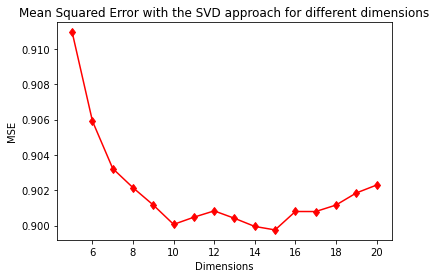

In [26]:
## Tests different dimensions to find the smallest error
def dim_test(data, dim_min, dim_max, n_folds, seed):
    err_min = np.PINF
    dim = None
    err_list = []
    for k in range(dim_min, dim_max + 1):
        err = svd_cross_validation(data, k, n_folds, seed)
        err_list.append(err)
        if err < err_min:
            err_min = err
            dim = k
    return dim, err, err_list

dim_min, dim_max = 5, 20
dim, err, err_list = dim_test(votes, dim_min, dim_max, 5, 10)

plt.plot(range(dim_min, dim_max + 1), err_list, 'd-r')
plt.title("Mean Squared Error with the SVD approach for different dimensions")
plt.ylabel("MSE")
plt.xlabel("Dimensions")
plt.show()

Therefore, we can see that the optimal number of dimensions is between 10 and 15. The error is higher before 10, and increses after 15. 

# Question 4 - Utilisez une approche par agglomération (clustering) pour prédire les votes et calculez l'erreur quadratique moyenne. Utilisez 5, 10, 20, 40 et 80 classes. Prenez l'approche K-moyenne (K-means) et utilisez la corrélation comme mesure de distance et une validation croisée de 5 replis pour établir les classes. 


In [78]:
## Auxiliary methods

## Fills missing data with the average for each value
def fill_missing(data):
    
    ## Gets average values
    avg_user = np.true_divide(data.sum(axis=1), (data != 0).sum(axis=1))
    avg_item = np.true_divide(data.sum(axis=0), (data != 0).sum(axis=0))
    
    ## For each user/item, inputs values
    for user_id, user in enumerate(data):
        for item_id, item in enumerate(user):
            if item == 0:
                val = 0
                div = 0
                if not np.isnan(avg_user[user_id]):
                    val += avg_user[user_id]
                    div += 1
                if not np.isnan(avg_item[item_id]):
                    val += avg_item[item_id]
                    div += 1
                data[user_id][item_id] = val / div

## Calculates the mean of each cluster
def compute_clusters_mean(data, clusters, nb_cluster):
    result = []
    for i in range(nb_cluster):
        mask = np.ma.masked_where(clusters == i, clusters).mask
        masked_data = data[mask]
        means = np.true_divide(masked_data.sum(0), (masked_data != 0).sum(0))
        result.append(means)

    return result

In [79]:
from sklearn.cluster import KMeans
from statistics import NormalDist

def calculate_kmeans(data, n_folds, n_cluster, seed):
    
    folds_data = cross_validation(data, n_folds, seed)
    overall_error = []   
    
    ## Masks zeroed values
    original_matrix = csr_matrix((data['rating'], (data['user.id'], data['item.id']))).toarray()
    missing_val = np.ma.masked_where(original_matrix == 0, original_matrix).mask

    ## Fills missing values
    filled_matrix = original_matrix.astype(float)
    fill_missing(filled_matrix)
    
    ## For each fold, calculates average error
    for fold in range(len(folds_data)):  
        
        ## Splits test-rating data with zeroes, and reinserts it into the overall data
        test_data = folds_data[fold]
        rating_data = test_data.copy()
        rating_data['rating'] = 0
        train_data = pd.concat(folds_data[:fold] + [rating_data] + folds_data[fold + 1:])
        train_matrix = csr_matrix((train_data['rating'], (train_data['user.id'], train_data['item.id']))).toarray()
        
        ## Using correlation as the similarity metric
        cor = np.corrcoef(train_matrix)

        ## Calculates K-Means
        kmeans = KMeans(n_clusters=n_cluster, random_state=5).fit(cor)
        clusters = kmeans.labels_

        ## Fills missing values in the train matrix
        train_matrix = train_matrix.astype(float)
        train_matrix[missing_val] = filled_matrix[missing_val]

        ## Creates array with mean for each cluster
        clusters_mean = np.array(compute_clusters_mean(train_matrix, clusters, n_cluster))
        
        ## Tests data
        err = []
        for _, vote in test_data.iterrows():
            cluster_num = clusters[vote["user.id"]]
            pred = clusters_mean[cluster_num][vote["item.id"]]
            dif = (vote["rating"] - pred)
            err.append(dif ** 2)
        
        overall_error.append(np.nanmean(err))
        
    return np.mean(overall_error)

### Running the K-Means algorithm with 5-fold cross validation and 5 clusters

In [80]:
calculate_kmeans(votes, 5, 5, 10)

1.0516267979792473

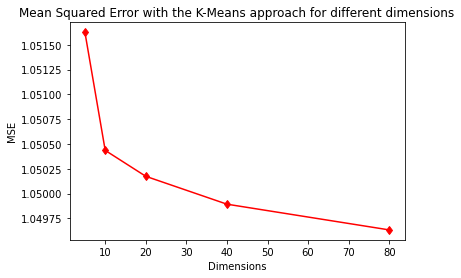

In [70]:
## Tests the algo with the dimmensions required by the TP
def dim_test(data, dimensions, n_folds, seed):
    err_min = np.PINF
    dim = None
    err_list = []
    for k in dimensions:
        err = calculate_kmeans(data, k, n_folds, seed)
        err_list.append(err)
        if err < err_min:
            err_min = err
            dim = k
    return dim, err, err_list

dimensions = [5, 10, 20, 40, 80]
dim, err, err_list = dim_test(votes, dimensions, 5, 10)

## Plots data
plt.plot(dimensions, err_list, 'd-r')
plt.title("Mean Squared Error with the K-Means approach for different dimensions")
plt.ylabel("MSE")
plt.xlabel("Dimensions")
from scipy.sparse import coo_matrix, csr_matrixuser.columns = [column.replace(" ", "") for column in user.columns];plt.show()

In [1]:
from scipy.sparse import csr_matrix

# Loads CSVs into Pandas variables
items = pd.read_csv('items.csv', delimiter= '|')
u = pd.read_csv('u.csv', delimiter= '|')
votes = pd.read_csv('votes.csv', delimiter= '|')

## adjusts columns in U datset
u.columns = [column.replace(" ", "") for column in u.columns];

## creates train matrix
train_matrix = csr_matrix((votes.loc[:, 'rating'], (votes.loc[:, 'user.id'], votes.loc[:, 'item.id'])))

## example hyperparameters
pro = "engineer"
sexe = "M"
age = 50

## the minimum grade that makes me like a movie
voteMin = 4

## selects rows based on the hyperparameters
pro_rows = u[u["job"]==pro].index.tolist()
sex_rows = u[u["gender"]==sexe].index.tolist()
age_rows = u[u["age"] > age-25][u["age"] < age+25].index.tolist()

## calculates Bayes Theorem for each hyperparameter
prob_job = np.sum(train_matrix[pro_rows,:] >= voteMin, axis=0).astype(float) / np.sum(train_matrix >= voteMin, axis=0)
prob_age = np.sum(train_matrix[age_rows,:] >= voteMin, axis=0).astype(float) / np.sum(train_matrix >= voteMin, axis=0)
prob_sex = np.sum(train_matrix[sex_rows,:] >= voteMin, axis=0).astype(float) / np.sum(train_matrix >= voteMin, axis=0)
prob_grade = np.sum(train_matrix >= voteMin, axis=0).astype(float) / np.sum(train_matrix > 0, axis=0)

## gets combined Bayes Theorem
comb_prob = np.multiply(prob_grade,np.multiply(prob_job,np.multiply(prob_age,prob_sex)))
prob = np.array(comb_prob)[0]
nb_nan = np.sum(np.isnan(prob))

## Selects and prints final recommended set
recomended = np.argsort(prob)[-(nb_nan + 11):-nb_nan][::-1]
result_set = items.loc[recomended]
print(result_set[:,  9]])

NameError: name 'pd' is not defined